<font size = "5"> **Lecture 5:  [Analysis of Images](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%205)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Analysis

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/raw/main/Lecture%205/0_Phase_Contrast_Image.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%205/0_Phase_Contrast_Image.ipynb)

part of Online Course

<font size = "5"> **[Machine Learning in Scanning Electron Microscopy 2023](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023)**</font>

<font size = "3"> **[Lecture 5](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%205)**</font>

by Gerd Duscher, 2023

Microscopy Facilities
Materials Science & Engineering<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

## Content

Information content in high-resolution phase contrast images


## Load important packages

### Check Installed Packages

In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy.git@main
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
    
# ------------------------------
print('done')

done


### Import all relevant libraries
Besides the ususal libraries we also load the blob detectors of the scipy-image package

In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../pyTEMlib')

In [3]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh

# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
from pyTEMlib import image_tools as it
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library


# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyTEM version: ',pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2023.5.2


## Fourier Analysis of Phase Contrast Images
### Load an atomic resolution image
As an example we will use again **p1-3-hr3.dm3** in the TEMdata directory. This image is of a nO particle on graphene.

In [5]:
# ---- Input ------
load_example = False
# -----------------

if load_example:
    file_name = '../example_data/p1-3-hr3.dm3'
    file_name = '../example_data/p1-hr3-ZnOonGraphite.dm3'

else:
    file_name = None
    

fileWidget = ft.FileWidget()

### Fourier Transform of Image

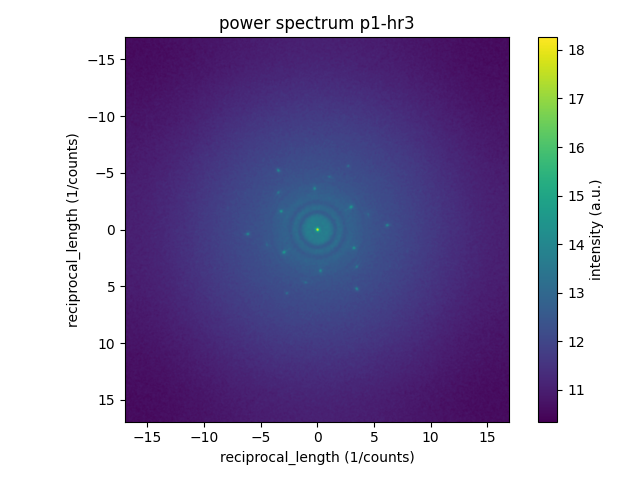

In [39]:
dataset = fileWidget.selected_dataset

fft_mag = it.power_spectrum(dataset)
view = fft_mag.plot()

### Spot Detection

Found 19 reflections


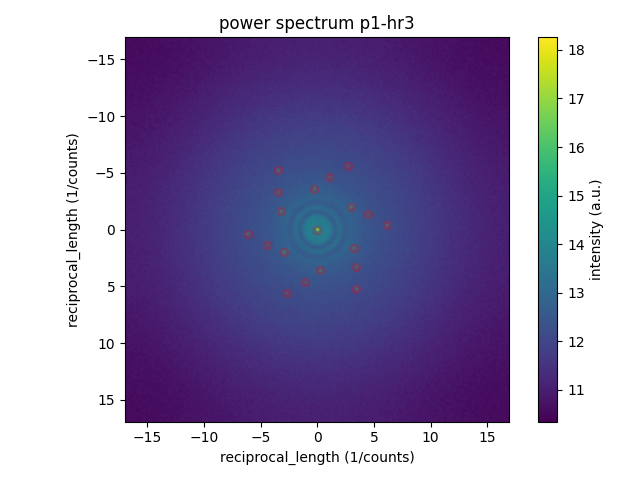

In [40]:
# ---- Input ---------
spot_threshold = .3
# --------------------
## pixel_size in recipical space
rec_scale_x = 1/dataset.x[-1]  
rec_scale_y = 1/dataset.y[-1]

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * dataset.shape[0] /2.
rec_FOV_y = rec_scale_y * dataset.shape[1] /2.


## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)

## Needed for conversion from pixel to Reciprocal space
rec_scale = np.array([rec_scale_x, rec_scale_y,1])
center = np.array([int(dataset.shape[0]/2), int(dataset.shape[1]/2),1] )


# spot detection ( for future referece there is no symmetry assumed here)

spots_random =  (blob_log(fft_mag,  max_sigma= 5 , threshold=spot_threshold)-center)*rec_scale

print(f'Found {spots_random.shape[0]} reflections')
spots_random[:,2] = np.linalg.norm(spots_random[:,0:2], axis=1)
spots_index = np.argsort(spots_random[:,2])
spots = spots_random[spots_index]

## plot Fourier transform and found spots
view = fft_mag.plot()
plt.gca().scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.2, label='spots');


### Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image,the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-path** area in the code below and notice the effects on the Fourier filtered image.



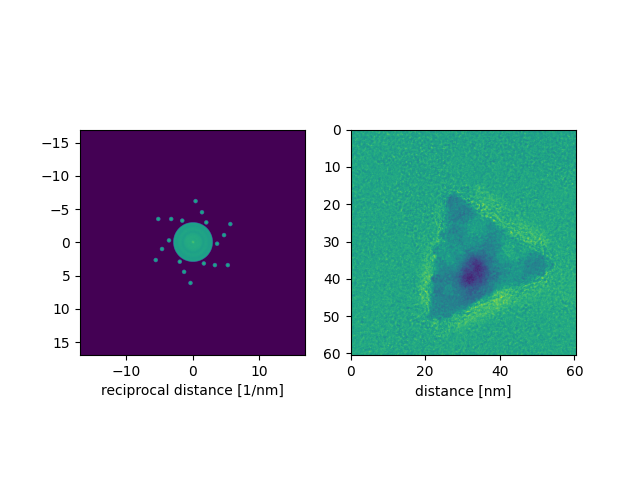

In [41]:
# Input 
reflection_radius = 0.3 # in 1/nm
low_pass = 1/.34 # in 1/nm diameter of mask for low pass filter
FOV_x = dataset.x[-1]
FOV_y = dataset.y[-1]


#prepare mask
pixels = (np.linspace(0,dataset.shape[0]-1,dataset.shape[0])-dataset.shape[0]/2)* rec_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(dataset.shape)

# mask reflections
for spot in spots:
    mask_spot = (x-spot[0])**2+(y-spot[1])**2 < reflection_radius**2 # make a spot 
    mask = mask + mask_spot# add spot to mask
    
# mask zero region larger (low-pass filter = intensity variations)

mask_spot = x**2+y**2 < low_pass**2 
mask = mask + mask_spot

mask[np.where(mask>1)]=1 # just in case of overlapping disks

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(np.array(dataset)))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered).T)

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real.T,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


### Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


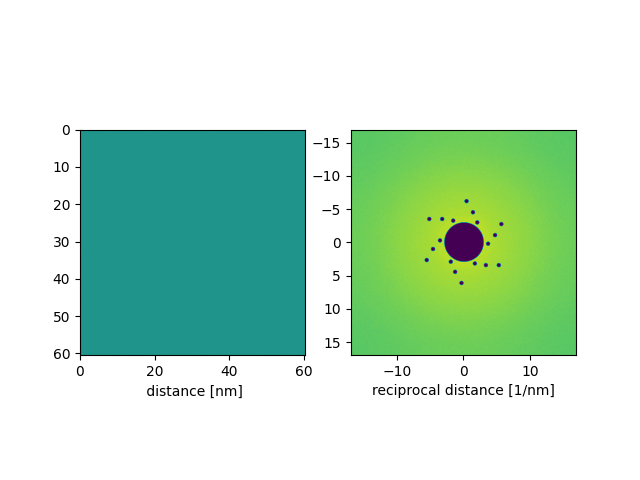

In [42]:
plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(dataset-filtered.real.T,extent=real_extent, origin = 'upper')
plt.xlabel(' distance [nm]')

ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(np.array(dataset-filtered.real.T)))
ax2.imshow(np.log(1+np.abs(fft_difference)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

### Rotational Symmetry

In our context of symmetry, we just need to deal with the discrete values of Θ = 2π/n for the angle of rotation.

In two dimensios we have then the rotation matrix:
$$C_{n-fold} = \left[\array{ \cos{( 2\pi/n)} & \sin{( 2\pi/n)}\\ -\sin{( 2\pi/n)} & \cos{ (2\pi/n)}\\}\right]$$

If we subtract all spots from all rotated spots we have a set of distances where for each spot there is minimal distance to the next spot.
If we have a very small distance for each original spot, we have a found rotational symmetry operation.  

In [43]:
from itertools import product

for n in [2,3,4,5,6]:
    C = np.array([[np.cos(2*np.pi/n), np.sin(2*np.pi/n),0],[-np.sin(2*np.pi/n), np.cos(2*np.pi/n),0], [0,0,1]])
    sym_spots = np.dot(spots,C)
    dif = []
    for p0, p1 in product(sym_spots[:,0:2], spots[:,0:2]):
        dif.append(np.linalg.norm(p0-p1))
    dif = np.array(sorted(dif))
    #print(dif[0:spots.shape[0]])
    if dif[int(spots.shape[0]*.7)] < 0.2:
        
        print(f'Found {n}-fold symmetry in diffraction pattern')
        

Found 2-fold symmetry in diffraction pattern
Found 3-fold symmetry in diffraction pattern
Found 6-fold symmetry in diffraction pattern


### Mirror symmetry

Any mirror axis has to go through the origin.

Let's consider the points as vectors and let's condier the miror axis as a vector field that lays on that axis.

The mirror axis of any point has to go through that point plus the half of the vector to another point.


Reflection across a line through the origin in two dimensions can be described by the following formula
$$\operatorname{Ref}_l(v) = 2\frac{v \cdot l}{l \cdot l}l - v,$$

where $v$ is the vector of a point, while $l$ is a vector on the mirror axis on which $v$ is reflected on. $v \cdot l$ denotes the dot product of $v$ and $l$. 


Found 0 mirror axes


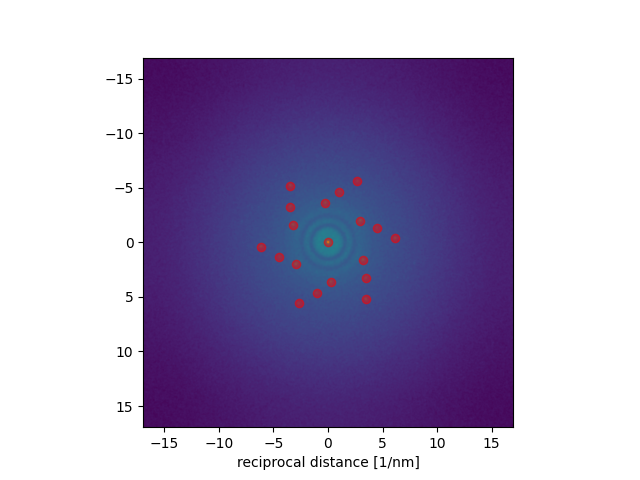

In [44]:
mirror_axes = []
plt.figure()
plt.imshow(fft_mag.T,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.5, label='spots');

for spot in spots:
    if spot[2] > .1:
        mirror_spots = []
        for spot2 in spots:
            if spot2[2]>.1:
                l = spot[0:2]+spot2[0:2]/2
                v = spot[0:2]
                ref = 2*np.dot(v,l) / np.dot(l,l)*l-v
                mirror_spots.append(ref)
        mirror_spots = np.array(mirror_spots)
        dif = []
        for p0, p1 in product(mirror_spots, spots[:,0:2]):
            dif.append(np.linalg.norm(p0-p1))
        dif = np.array(sorted(dif))
        #print(dif[0:25])
        #print(int(spots.shape[0]/2))
        #print(dif[int(spots.shape[0]/2)])
        if dif[int(spots.shape[0]/2)] < 0.5:
            #print(l,dif[0:25])
            mirror_axes.append(l)
            axis=l/np.linalg.norm(l)
            plt.plot([-l[1],l[1]],[-l[0],l[0]],c='yellow')
            print(f'Found mirror {axis} axis in diffraction pattern')
print(f'Found {len(mirror_axes)} mirror axes')


## Quantitative Analysis
### Reference Crystals

In [45]:
graphite  = ks.structure_by_name('Graphite')
zno = ks.structure_by_name('ZnO')
### Define exxperimental parameters:
tags_experiment= {}
tags_experiment['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = 30
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array([0,0,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_experiment['Sg_max'] = .02 # 1/Ang  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 2  # Highest evaluated Miller indices


######################################
# Diffraction Simulation of Graphite #
######################################
graphite.info['experimental'] = tags_experiment
ks.kinematic_scattering(graphite, False)

######################################
# Diffraction Simulation of ZnO      #
######################################
zno.info['experimental'] = tags_experiment
ks.kinematic_scattering(zno, False)

The diffraciton calculation is in Angstrom (or better 1/Ang) but the image is in nm.
So we convert to 1/nm

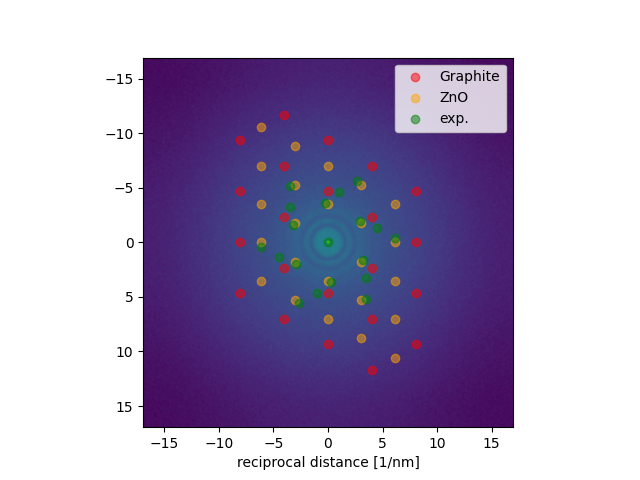

In [46]:

spots_Graphite = graphite.info['diffraction']['allowed']['g']*10
spots_ZnO = zno.info['diffraction']['allowed']['g']*10

resolution = 0.1#nm

plt.figure()
plt.imshow(fft_mag.T,extent=np.array(rec_extend), origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_Graphite[:,0], spots_Graphite[:,1], c='Red',  alpha = 0.5, label='Graphite');
plt.scatter(spots_ZnO[:,0], spots_ZnO[:,1], c='orange',  alpha = 0.5, label='ZnO');
plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5, label='exp.');

plt.legend(loc=1);

### Reflections in Polar Coordinates 
A more interesting way of comparing a simulation and experiment is to compare the spots in polar coordinates:

conversion to Euclidean space:
$$\begin{align}
  x &= r \cos\varphi \\
  y &= r \sin\varphi
\end{align}$$

conversion to polar coordinates:
$$\begin{align}
r &= \sqrt{x^2 + y^2} \\
\varphi &= \operatorname{atan2}(y, x) 
\end{align}$$

 Rotated Graphite SAD by -16.7°
 Rotated ZnO SAD by 146.0°


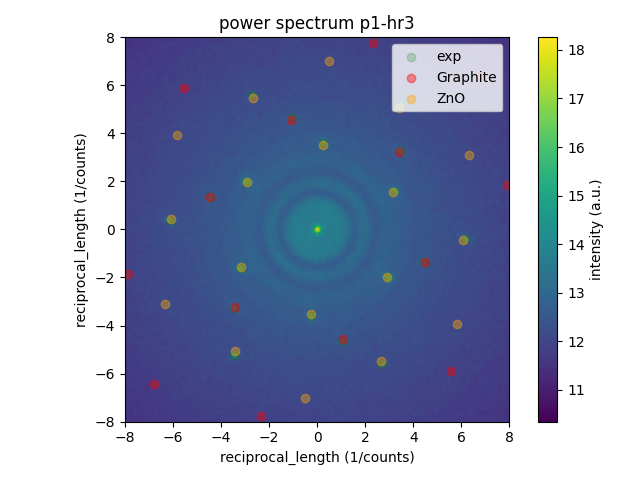

In [47]:
##  Polar Coordinates of experimental and reference lattice

def cart2pol(points):
    rho = np.linalg.norm(points[:,0:2], axis=1)
    phi = np.arctan2(points[:,1], points[:,0])
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def xy2polar(points, rounding = 1e-3):
    """
    Conversion from carthesian to polar coordinates
    
    the angles and distances are sorted by r and then phi
    The indices of this sort is also returned
    
    input points: numpy array with number of points in axis 0 first two elements in axis 1 are x and y
    
    optional rounding in significant digits 
    
    returns r,phi, sorted_indices
    """
    
    r,phi = cart2pol(points)
    
    phi = phi-phi.min() # only positive angles
    r = (np.floor(r/rounding) )*rounding # Remove rounding error differences

    sorted_indices = np.lexsort((phi,r) ) # sort first by r and then by phi
    r = r[sorted_indices]
    phi = phi[sorted_indices]
    
    return r, phi, sorted_indices

## Transfer everything to polar coordinates 
graphite_r, graphite_phi, graphite_indices = xy2polar(spots_Graphite) #sorted by r and phi , only positive angles
ZnO_r, ZnO_phi, ZnO_indices = xy2polar(spots_ZnO)
exp_r, exp_phi = cart2pol(spots) # just in polar coordinates

angleI = np.argmin(np.abs(exp_r-graphite_r[0]) )
angle = exp_phi[angleI] - graphite_phi[0] ## Determine rotation angle

graphite_phi = graphite_phi + angle # rotation
print(f" Rotated Graphite SAD by {np.degrees(angle):.1f}°")


angleI2 = np.argmin(np.abs(exp_r-ZnO_r[0]) )
angle2 = exp_phi[angleI2] - ZnO_phi[0] ## Determine rotation angle


ZnO_phi = ZnO_phi + angle2 # rotation
print(f" Rotated ZnO SAD by {np.degrees(angle2):.1f}°")


fft_mag.plot()

x, y= pol2cart(exp_r, exp_phi)
plt.scatter(x,y, c='green',  alpha = 0.2,label='exp')

x, y= pol2cart(graphite_r, graphite_phi)
plt.scatter(x,y, c='red',  alpha = 0.4,label='Graphite')

x,y = pol2cart(ZnO_r, ZnO_phi)
plt.scatter(x,y, c='orange',  alpha = 0.4,label='ZnO')



plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1);


In [48]:
dist_graphite, np.sum(spots_experiment, axis=1)
dist_graphite = np.linalg.norm(spots_reference, axis=1),
dist_graphite, distance_experiment
first_reflections

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

### Calibrate Distortions with Reference Crystal

In [49]:
g = gx = gy = rec_scale_x

spots_reference = np.array(pol2cart(graphite_r, graphite_phi)).T
#spots_reference = np.array(pol2cart(ZnO_r, ZnO_phi)).T

spots_experiment = spots[:,0:2]
dist_graphite = np.linalg.norm(spots_reference, axis=1)

distance_experiment = np.linalg.norm(spots_experiment, axis=1)
first_reflections = abs(distance_experiment - dist_graphite.min()) < .1
print('Evaluate ', first_reflections.sum(), 'reflections')
reference_reflections = spots_experiment[first_reflections]

import scipy.optimize as optimization
def func(params, xdata, ydata):
    dgx , dgy = params
    return (np.sqrt((xdata*dgx)**2 + (ydata*dgy)**2 ) - dist_graphite.min())

x0 = [1.,0.999]
[dgx, dgy], sig = optimization.leastsq(func, x0, args=(reference_reflections[:,0], reference_reflections[:,1]))

print('distortion x:', dgx, 'y: ', dgy) 
gx /=dgx
gy /=dgy

spots_experiment = spots_experiment*(dgx,dgy)


Evaluate  6 reflections
distortion x: 1.000736098442606 y:  0.9775413859140643


### Plot Corrected Image and Reference Lattice

C:\Users\gduscher\AppData\Local\Temp\ipykernel_7708\335324064.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


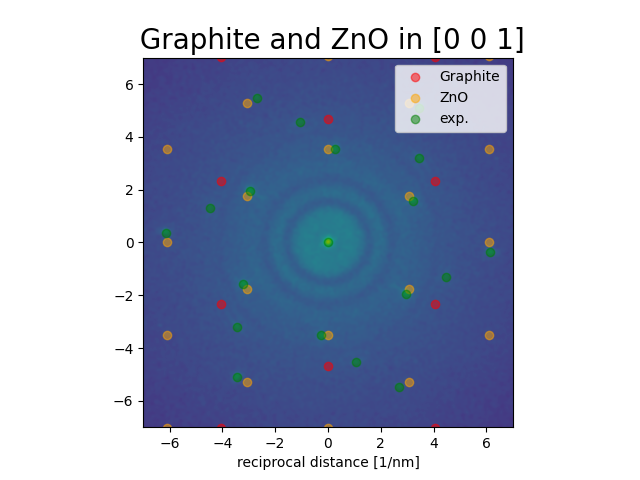

In [50]:
FOV_cor = (0,FOV_x/dgx,FOV_y/dgy,0)
rec_FOV_cor = (-rec_FOV_x*dgx,rec_FOV_x*dgx,rec_FOV_y*dgy,-rec_FOV_y*dgy)

plt.figure()
plt.title(' Graphite and ZnO in ' + str(graphite.info['experimental']['zone_hkl']), fontsize=20)     

plt.imshow(fft_mag.T,extent=rec_FOV_cor, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_Graphite[:,0], spots_Graphite[:,1], c='Red',  alpha = 0.5, label='Graphite');
plt.scatter(spots_ZnO[:,0], spots_ZnO[:,1], c='orange',  alpha = 0.5, label='ZnO');
plt.scatter(spots[:,0]*dgx, spots[:,1]*dgy, c='green',  alpha = 0.5, label='exp.');

plt.xlim(-7,7)
plt.ylim(-7,7)
plt.legend(loc=1)


(22,)
[0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.52359878 1.57079633 2.61799388 3.66519143 4.71238898 5.75958653
 0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.33347317 0.71372438 3.47506583 3.85531703]
136.4999208190518 2.3823730470040085 0.0


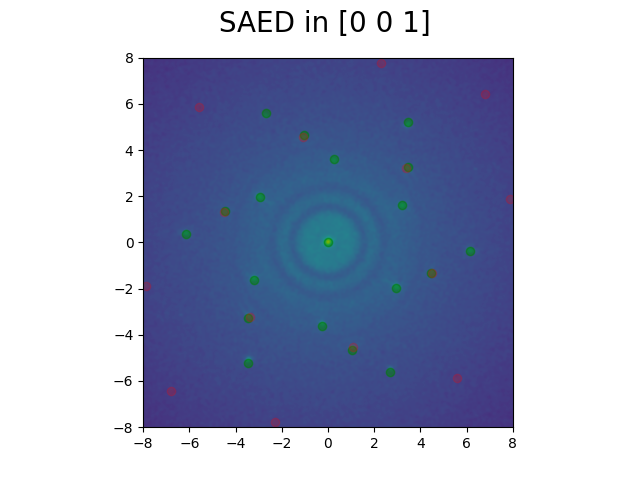

In [51]:
##  Polar Coordinates of experimental and reference lattice

graphite_r = np.linalg.norm(spots_Graphite, axis=1)
graphite_theta = np.arctan2(spots_Graphite[:,1], spots_Graphite[:,0])
print(graphite_r.shape)

graphite_theta = graphite_theta-graphite_theta.min() # only positive angles
graphite_r = (np.floor(graphite_r*1000) )/1000. # Remove rounding error differences

graphite_sorted= np.lexsort((graphite_theta,graphite_r) ) # sort first by r and then by theta
graphite_r = graphite_r[graphite_sorted]
graphite_theta = graphite_theta[graphite_sorted]#-graphite_theta.min() ## lets have all angles positive and sorted
print((graphite_theta))

exp_r = np.linalg.norm(spots[:,0:2], axis=1)
exp_theta = np.arctan2(spots[:,1], spots[:,0])

exp_r = (np.floor(exp_r*100) )/100. # Remove rounding error differences
exp_theta = exp_theta -exp_theta.min()
exp_sorted= np.lexsort((exp_theta,exp_r) ) # sort first by r and then by theta

exp_r = exp_r[exp_sorted]
exp_theta = exp_theta[exp_sorted]

angleI = np.argmin(np.abs(exp_r-graphite_r[0]) )
angle = exp_theta[angleI] - graphite_theta[0] 

print(np.degrees(angle), exp_theta[angleI], graphite_theta[0] )

graphite_theta = graphite_theta - angle


#p_graphite =  np.dot(tags_Graphite['allowed']['g'][tags_Graphite['allowed']['ZOLZ']],r_mat)

fig = plt.figure()
fig.suptitle(' SAED in ' + str(graphite.info['experimental']['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag.T,extent=rec_FOV_cor, origin = 'upper')

x = np.cos(graphite_theta)* graphite_r
y = np.sin(graphite_theta)* graphite_r

plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5,
           label='spots')
plt.scatter(x,y, c='red',  alpha = 0.2,
           label='Graphite')
plt.xlim(-8,8);plt.ylim(-8,8)
plt.show()


 Rotated Graphite SAD by -16.7°
 Rotated ZnO SAD by 146.0°


C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


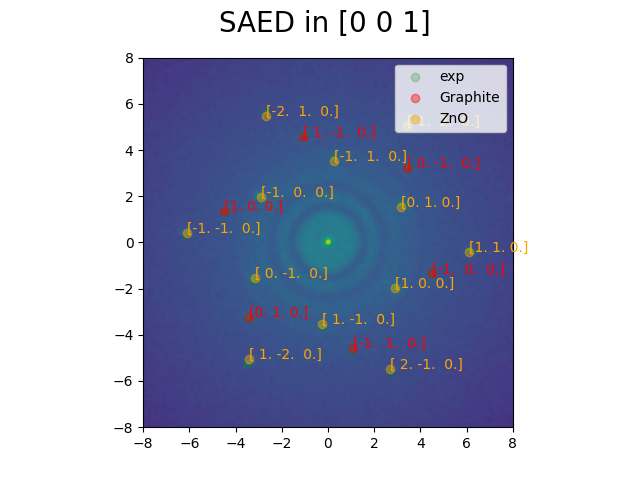

In [52]:
## Transfer everything to polar coordinates 
graphite_r, graphite_phi, graphite_indices = xy2polar(spots_Graphite) #sorted by r and phi , only positive angles
ZnO_r, ZnO_phi, ZnO_indices = xy2polar(spots_ZnO)
exp_r, exp_phi = cart2pol(spots) # just in polar coordinates

resolution = 1/exp_r.max()
visible_Graphite = graphite_r < 1/resolution
visible_ZnO = ZnO_r  < 1/resolution


angleI = np.argmin(np.abs(exp_r-graphite_r[0]) )
angle = exp_phi[angleI] - graphite_phi[0] ## Determine rotation angle

graphite_phi = graphite_phi + angle # rotation
print(f" Rotated Graphite SAD by {np.degrees(angle):.1f}°")


angleI2 = np.argmin(np.abs(exp_r-ZnO_r[0]) )
angle2 = exp_phi[angleI2] - ZnO_phi[0] ## Determine rotation angle


ZnO_phi = ZnO_phi + angle2 # rotation
print(f" Rotated ZnO SAD by {np.degrees(angle2):.1f}°")


fig = plt.figure()
fig.suptitle(' SAED in ' + str(graphite.info['experimental']['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag.T,extent=rec_extend, origin = 'upper')

x, y= pol2cart(exp_r, exp_phi)
plt.scatter(x,y, c='green',  alpha = 0.2,label='exp')

x, y= pol2cart(graphite_r[visible_Graphite], graphite_phi[visible_Graphite])
plt.scatter(x,y, c='red',  alpha = 0.4,label='Graphite')

for i in range(len(graphite_r)):
    if visible_Graphite[i]:
        plt.text(x[i],y[i], graphite.info['diffraction']['allowed']['hkl'][graphite_indices[i]],color='red')

x,y = pol2cart(ZnO_r[visible_ZnO], ZnO_phi[visible_ZnO])
plt.scatter(x,y, c='orange',  alpha = 0.4,label='ZnO')
for i in range(len(visible_ZnO)):
    if visible_ZnO[i]:
        plt.text(x[i],y[i], zno.info['diffraction']['allowed']['hkl'][ZnO_indices[i]], color='orange')


plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1);


### Plot Histograms of Distances

Next we want to plot the radially summed profile of the diffractogram and compare it with the contrast transfer function.

In [53]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def cartesian2polar(x, y, grid, r, t, order=3):

    R,T = np.meshgrid(r, t)

    new_x = R*np.cos(T)
    new_y = R*np.sin(T)

    ix = interp1d(x, np.arange(len(x)))
    iy = interp1d(y, np.arange(len(y)))

    new_ix = ix(new_x.ravel())
    new_iy = iy(new_y.ravel())

    
    return map_coordinates(grid, np.array([new_ix, new_iy]),
                            order=order).reshape(new_x.shape)

def warp(diff):
    # Define original polar grid
    nx = diff.shape[0]
    ny = diff.shape[1]

    x = np.linspace(1, nx, nx, endpoint = True)-center[1]
    y = np.linspace(1, ny, ny, endpoint = True)-center[0]
    z = diff

    # Define new polar grid
    nr = min([center[0], center[1], diff.shape[0]-center[0], diff.shape[1]-center[1]])-1
    nt = 360*3


    r = np.linspace(1, nr, nr)
    t = np.linspace(0., np.pi, nt, endpoint = False)
    return cartesian2polar(x,y, z, r, t, order=3).T

### Plot Distances and CTF

-0.6444267911376953
[ 3.33329002  3.28663452  3.18789323 ... -0.64423852 -0.64439877
 -0.64442679]
Scherzer defocus is -271.3 nm


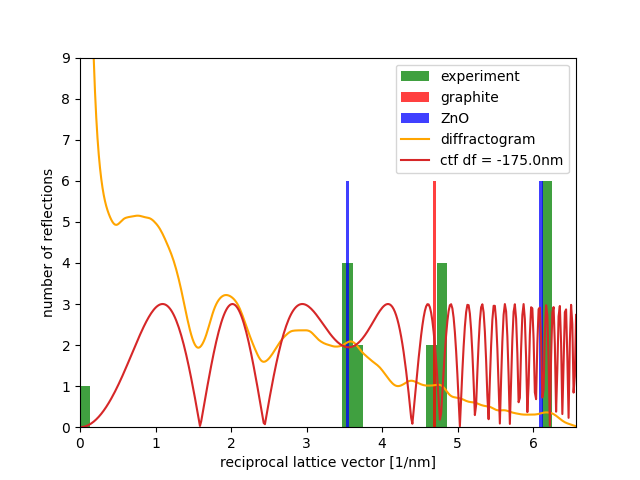

In [54]:
# --------- Input -----------
Cs = 2.2
defocus = -175 # underfocus is negative
acceleration_voltage = 200*1e3
# ---------------------------------
wavelength = ks.get_wavelength(acceleration_voltage) # in nm


polar_projection = warp(fft_mag)
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)
profile = (profile-profile[1:400].min())/profile.max()*10
print(profile[-1])

k =np.linspace(1,len(profile),len(profile))*rec_scale_x
print (profile)

def calculateScherzer(wavelength, Cs):
    # Calculate the Scherzer defocus. Cs is in mm, lambda is in nm
    # Everything is trasnfered to m
    #The returned value is in nm
    Cs=Cs*1e-3 # now in m
    scherzer=-1.155*(Cs*wavelength*1e-9)**0.5 # in m
    scherzer=scherzer*1e9 # convert to nm
    return scherzer

scherzer =calculateScherzer(wavelength, Cs)

print(f'Scherzer defocus is {scherzer:.1f} nm')

def calculateCTF(wavelength, Cs, defocus,k3):
    # everything in nm
    Cs=Cs*10**6
    ctf=np.sin(np.pi*defocus*wavelength*k**2+0.5*np.pi*Cs*wavelength**3*k**4)
    return ctf
ctf = calculateCTF(wavelength/10, Cs, defocus,k)


fig = plt.figure()
plt.hist(exp_r,45,facecolor='green', alpha=0.75, label='experiment')
plt.hist(graphite_r,200,facecolor='red', alpha=0.75, label='graphite')
plt.xlim(0,exp_r.max()*1.05)

plt.hist(ZnO_r,200,facecolor='blue', alpha=0.75, label='ZnO')
plt.plot(k,profile/profile.max()*20,c='orange',label='diffractogram' );
plt.plot(k,np.abs(ctf)*3, label = f'ctf df = {defocus:.1f}nm')
#plt.hist(np.linalg.norm(p_ZnO, axis=1),200,facecolor='orange', alpha=0.75, label='hexagonal ZnO')
plt.legend()
plt.xlabel('reciprocal lattice vector [1/nm]')
plt.ylabel('number of reflections')

plt.ylim(0,9)

plt.show()

## Another Image
Go back to [Load an atomic resolution image](#Load-an-atomic-resolution-image)

Try the same procedure with image **p1-hr4-ZnOonGraphite.dm3** in the TEMdata directory, which is taken with a different defocus (which one?)

## Conclusion:
We see that we can calibrate an image with sub pm precission if the lattice of a reference crystal is resolved.
The original image scale and distortion was accurate within less than 2%. A quite respectable result, if one takes into account that the objective stigmators and the objecitve focus vary from image to image. These electron optic values will change the magnification of course. 

This will not be possible in a scanning transmission electron microscop HAADF image, due to sample drift and instabilities.